In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from scipy.io import loadmat
from tqdm import tqdm
import multiprocessing as mp
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import PIL.ImageOps as pop
import seaborn as sns
%matplotlib inline

In [3]:
fpX = np.float32
from src.numpy_utility import mosaic_vis, iterate_minibatches
from src.file_utility import save_stuff

In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [4]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print ("Current dir: %s" % root_dir)
print ("Time Stamp: %s" % timestamp)

Current dir: /user_data/mmhender/nsd-master/
Time Stamp: Apr-30-2021_1859


In [5]:
def applyCropToImg(img, box):
    '''
    applyCropToImg(img, cropBox)
    img ~ any h x w x n image
    cropBox ~ (top, bottom, left, right) in fractions of image size
    '''
    if box[0]+box[1] >= 1:
        raise ValueError('top and bottom crop must sum to less than 1')
    if box[2]+box[3] >= 1:
        raise ValueError('left and right crop must sum to less than 1')
    shape = img.shape
    topCrop = np.round(shape[0]*box[0]).astype(int)
    bottomCrop = np.round(shape[0]*box[1]).astype(int)
    leftCrop = np.round(shape[1]*box[2]).astype(int)
    rightCrop = np.round(shape[1]*box[3]).astype(int)
    croppedImage = img[topCrop:(shape[0]-bottomCrop),leftCrop:(shape[1]-rightCrop)]
    return croppedImage

def maskToIndices(img):
    return img[:,:,0]+img[:,:,1]*256+img[:,:,2]*(256**2)
def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return imgSegIds

def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return np.unique(imgSegIds)
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

def getCategoryNames(catIdToCat, catIds):
    # getCategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['name'] for c in catIds])
def getSupercategoryNames(catIdToCat, catIds):
    # getSupercategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['supercategory'] for c in catIds])

def supercategoryMap(croppedImg, annotations, embbeding):
    # supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    segmentMap = maskToIndices(croppedImg).flatten()
    superMap = np.full(fill_value=-1, shape=segmentMap.shape, dtype=np.int)
    imgSegIds = maskToUniqueIndices(croppedImg)
    catIds = getCategoryIDs(annotations, imgSegIds)
    for c,s in zip(catIds, imgSegIds):
        supercat = getSupercategoryNames(catIdToCat, [c])[0]
        superMap[segmentMap==s] = embbeding[supercat]            
    return superMap.reshape(croppedImg.shape[:2])

## Load a dataset

In [6]:
# nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [7]:
exp_design = loadmat(exp_design_file)

In [8]:
print (exp_design.keys())

dict_keys(['__header__', '__version__', '__globals__', 'basiccnt', 'masterordering', 'sharedix', 'stimpattern', 'subjectim'])


In [9]:
basic_cnt    = exp_design['basiccnt']
shared_idx   = exp_design['sharedix']
subject_idx  = exp_design['subjectim']
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']

In [10]:
print (np.min(trial_order), np.max(trial_order))

1 10000


In [11]:
print ("Loading block...")
image_data_set = h5py.File(stim_file, 'r')
print (image_data_set.keys())
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print (image_data.shape)

Loading block...
<KeysViewHDF5 ['imgBrick']>
(73000, 425, 425, 3)


In [ ]:
import time
t = time.time()
print ("Loading block...")
image_data_set = h5py.File(stim_file, 'r')
print (image_data_set.keys())
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print (image_data.shape)
elapsed =time.time() - t
print('elapsed time is %.2f'%elapsed)

Loading block...
<KeysViewHDF5 ['imgBrick']>


In [12]:
print (shared_idx.shape)
print (np.min(shared_idx), np.max(shared_idx))

(1, 1000)
2951 72949


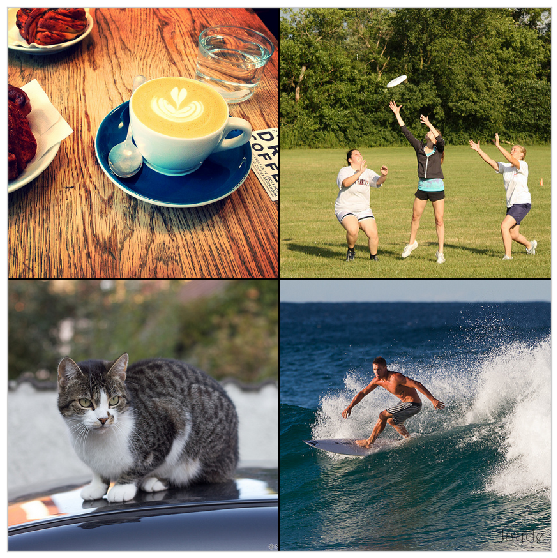

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(mosaic_vis(image_data[shared_idx[0,6:10]-1].astype(np.float32), pad=2), cmap='gray', interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

---

# Subject-wise image block
## Native resolution

In [16]:
savedir = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
os.makedirs(savedir)

for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1].transpose(0,3,1,2)
    print (s_image_data.shape)
    fn2save = os.path.join(savedir, '')
    print('saving to %sS%d_stimuli_native'%(savedir, k+1))
    save_stuff("%sS%d_stimuli_native"%(savedir, k+1), {'stimuli': s_image_data})

(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S1_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S2_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S3_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S4_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S5_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S6_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S7_stimuli_native
saved stimuli in h5py file
(10000, 3, 425, 425)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S8_stimuli_native
saved stimuli in h5py file


## Downsampled resolution

In [17]:
def resize_image_tensor(x, newsize):
    tt = x.transpose((0,2,3,1))
    r  = np.ndarray(shape=x.shape[:1]+newsize+(x.shape[1],), dtype=tt.dtype) 
    for i,t in enumerate(tt):
        r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))
    return r.transpose((0,3,1,2))   

In [18]:
nx = 227
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1]
    s_image_data = resize_image_tensor(s_image_data.transpose(0,3,1,2), newsize=(nx,nx))

    print (s_image_data.shape)
    print ('saving to %sS%d_stimuli_%d'%(savedir, k+1, nx))
    save_stuff("%sS%d_stimuli_%d"%(savedir, k+1, nx), {'stimuli': s_image_data})

(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S1_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S2_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S3_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S4_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S5_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S6_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S7_stimuli_227
saved stimuli in h5py file
(10000, 3, 227, 227)
saving to /user_data/mmhender/nsd_stimuli/stimuli/nsd/S8_stimuli_227
saved stimuli in h5py file


# COCO indices
## Create a block of COCO IDs concordant with the 'subjectim' array 

In [19]:
import pandas as pd
nsd_stiminfo_file = '~/repo.data/datasets/nsd/dev/nsd_stim_info_merged.pkl'
stiminfo = pd.read_pickle(nsd_stiminfo_file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mmhender/repo.data/datasets/nsd/dev/nsd_stim_info_merged.pkl'

In [16]:
subject_idx  = exp_design['subjectim']
print (subject_idx.shape)

cocoId_arr = np.zeros(shape=subject_idx.shape, dtype=int)
crop_arr   = np.zeros(shape=subject_idx.shape+(4,), dtype=np.float32)
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    imageId = subject_idx[j]-1
    for i,k in enumerate(imageId):
        cocoId_arr[j,i] = (cocoId[nsdId==k])[0]
        crop_arr[j,i]   = stiminfo['cropBox'][k]

(8, 10000)


## Reload 

In [17]:
subject = 1

In [18]:
coco_info_set = h5py.File(stim_root + 'nsd_to_coco_indice_map.h5py', 'r')
cocoId_arr = np.copy(coco_info_set['cocoId'])
nsdcrop_arr = np.copy(coco_info_set['crop'])
coco_info_set.close()

print (cocoId_arr.shape)
print (nsdcrop_arr.shape)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(8, 10000)
(8, 10000, 4)
(10000, 3, 227, 227)
uint8
0 255


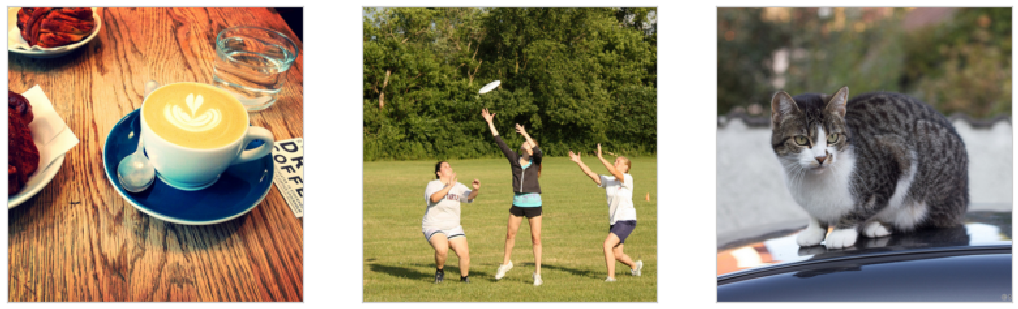

In [19]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [20]:
import json
from collections import defaultdict

annDir = '/home/styvesg/repo.data/datasets/coco/'
imgDir = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic/' # combined folder with train2017 and val2017 png masks
panop_trn_annFile = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic_train2017.json'
panop_val_annFile = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic_val2017.json'

dataset = dict()
dataset = json.load(open(panop_trn_annFile, 'r'))

imgIdToAnns = defaultdict(list)
catIdToCat = defaultdict(list)
if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)
    for cat in dataset['categories']:
        catIdToCat[cat['id']].append(cat)
        
dataset = dict()
dataset = json.load(open(panop_val_annFile, 'r'))

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

524646
/home/styvesg/repo.data/datasets/coco/panoptic_annotations_trainval2017/annotations/panoptic/000000524646.png
[9, 9, 184, 1, 154, 192, 42, 155, 9, 187]
['boat' 'mountain-merged' 'person' 'sand' 'sea' 'sky-other-merged'
 'surfboard' 'tree-merged']
['ground' 'person' 'plant' 'sky' 'solid' 'sports' 'vehicle' 'water']


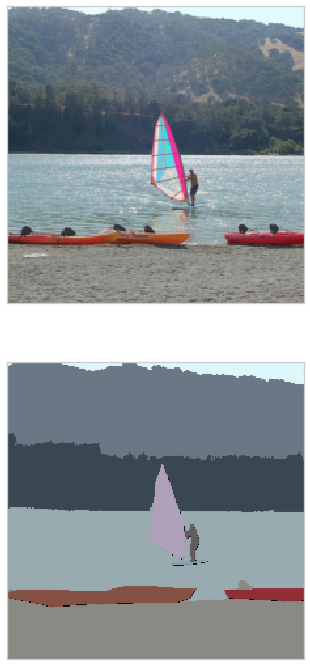

In [21]:
import skimage.io
from skimage.transform import resize

minSize = 227
start_idx = 3
n_idx = 1

plt.figure(figsize=(18,12))
for i in range(n_idx):
    nId = start_idx+i
    cId = cocoId_arr[subject-1, nId]
    print (cId)
    png_name = imgDir + '%012d.png' % cId
    print (png_name)
    crop = nsdcrop_arr[subject-1, nId]
    img = skimage.io.imread(png_name)

    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')

    plt.subplot(2,n_idx,i+1)
    plt.imshow(image_data[start_idx+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.imshow(croppedImg, alpha=.2)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(2,n_idx,n_idx+i+1)
    plt.imshow(croppedImg) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    ###
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    print (catIds)
    print (getCategoryNames(catIdToCat, catIds))
    print (getSupercategoryNames(catIdToCat, catIds))

In [22]:
stuff_annFile = annDir + 'stuff_annotations_trainval2017/annotations/stuff_train2017.json'
thing_annFile = annDir + 'annotations_trainval2017/annotations/instances_train2017.json'

from pycocotools.coco import COCO
coco_stuff = COCO(stuff_annFile)
coco_thing = COCO(thing_annFile)

ImportError: /home/styvesg/Documents/PostDoc/GitRepo/cocoapi/PythonAPI/pycocotools/_mask.so: undefined symbol: _Py_ZeroStruct

In [79]:
# display COCO categories and supercategories
cats = coco_stuff.loadCats(coco_stuff.getCatIds())
stuff_nms=[cat['name'] for cat in cats]
print('COCO stuff categories: \n{}\n'.format(' '.join(stuff_nms)))
super_stuff_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO stuff supercategories: \n{}'.format(' '.join(set(super_stuff_nms))))

print ()
cats = coco_thing.loadCats(coco_thing.getCatIds())
thing_nms=[cat['name'] for cat in cats]
print('COCO thing categories: \n{}\n'.format(' '.join(thing_nms)))
super_thing_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO thing supercategories: \n{}'.format(' '.join(set(super_thing_nms))))

print ()
super_nms = super_thing_nms + super_stuff_nms
print('COCO supercategories: \n{}'.format(' '.join(set(super_nms))))

COCO stuff categories: 
banner blanket branch bridge building-other bush cabinet cage cardboard carpet ceiling-other ceiling-tile cloth clothes clouds counter cupboard curtain desk-stuff dirt door-stuff fence floor-marble floor-other floor-stone floor-tile floor-wood flower fog food-other fruit furniture-other grass gravel ground-other hill house leaves light mat metal mirror-stuff moss mountain mud napkin net paper pavement pillow plant-other plastic platform playingfield railing railroad river road rock roof rug salad sand sea shelf sky-other skyscraper snow solid-other stairs stone straw structural-other table tent textile-other towel tree vegetable wall-brick wall-concrete wall-other wall-panel wall-stone wall-tile wall-wood water-other waterdrops window-blind window-other wood other

COCO stuff supercategories: 
building textile plant floor raw-material sky ceiling water solid window food-stuff furniture-stuff structural other wall ground

COCO thing categories: 
person bicycle ca

In [80]:
print 'super category count = ', len(super_nms)
class_embbeding, label_map = {}, {}
for k,name in enumerate(super_nms):
    class_embbeding[name] = k
    label_map[k] = name 
    print name, ': ', coco_thing.getCatIds(supNms=[name]) + coco_stuff.getCatIds(supNms=[name])

super category count =  28
outdoor :  [10, 11, 13, 14, 15]
food :  [52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
indoor :  [84, 85, 86, 87, 88, 89, 90]
appliance :  [78, 79, 80, 81, 82]
sports :  [34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
person :  [1]
animal :  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
vehicle :  [2, 3, 4, 5, 6, 7, 8, 9]
furniture :  [62, 63, 64, 65, 67, 70]
accessory :  [27, 28, 31, 32, 33]
electronic :  [72, 73, 74, 75, 76, 77]
kitchen :  [44, 46, 47, 48, 49, 50, 51]
building :  [95, 96, 128, 151, 158, 166]
water :  [120, 148, 155, 178, 179]
plant :  [94, 97, 119, 124, 129, 134, 142, 163, 169]
floor :  [101, 114, 115, 116, 117, 118]
raw-material :  [100, 132, 139, 143]
sky :  [106, 157]
ceiling :  [102, 103]
textile :  [92, 93, 104, 105, 109, 131, 137, 141, 152, 167, 168]
solid :  [127, 135, 150, 160, 162, 182]
window :  [180, 181]
food-stuff :  [121, 122, 153, 170]
furniture-stuff :  [98, 107, 108, 110, 112, 123, 130, 133, 156, 161, 165]
ground :  [111, 125, 126, 136, 140,

In [126]:
print (cocoMap[3938])

527257


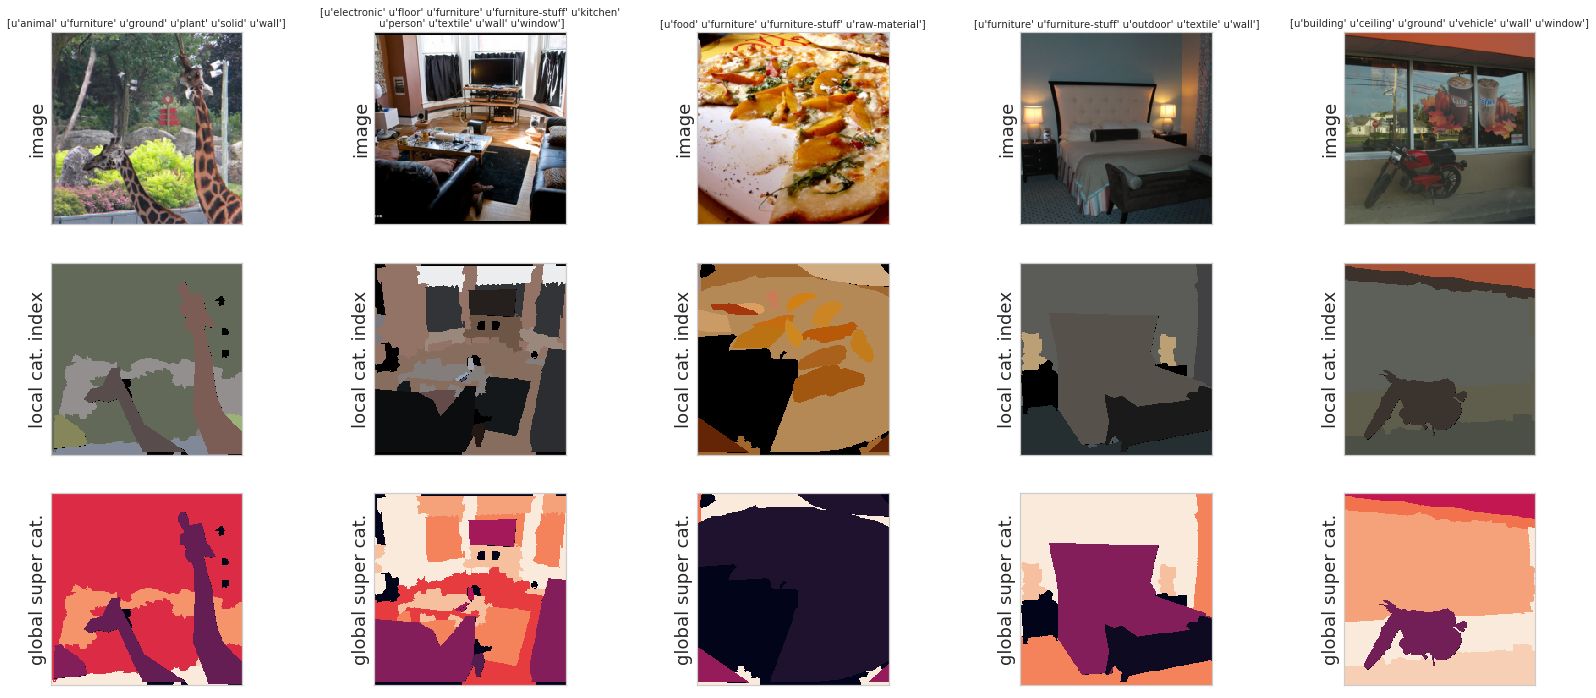

In [128]:
import skimage.io
from skimage.transform import resize
minSize = 227
start_idx = 3938
n_idx = 5

plt.figure(figsize=(28,12))
for i in range(n_idx):
    cId = cocoId_arr[subject-1,start_idx+i]
    png_name = imgDir + '%012d.png' % cId
    crop = nsdcrop_arr[subject-1,start_idx+i]
    img = skimage.io.imread(png_name)
    
    croppedImg = applyCropToImg(img,crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')
    
    catIds = getCategoryIDs(imgIdToAnns[cId], maskToUniqueIndices(croppedImg))   
    plt.subplot(3,n_idx,i+1)  
    plt.title(getSupercategoryNames(catIdToCat, catIds), fontsize=10)    
    plt.ylabel('image')
    plt.imshow(image_data[start_idx+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(3,n_idx,n_idx+i+1)
    plt.imshow(croppedImg)
    plt.ylabel('local cat. index')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(3,n_idx,2*n_idx+i+1)
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    plt.ylabel('global super cat.')
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])

In [136]:
cocoMap = np.ones(shape=(73000), dtype=int) * -1
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)] 
    cocoMap[nsdId] = cocoId
print (np.sum(cocoMap==-1))
print (cocoMap.shape)
print (stiminfo['cropBox'].shape)

0
(73000,)
(73000,)


In [159]:
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

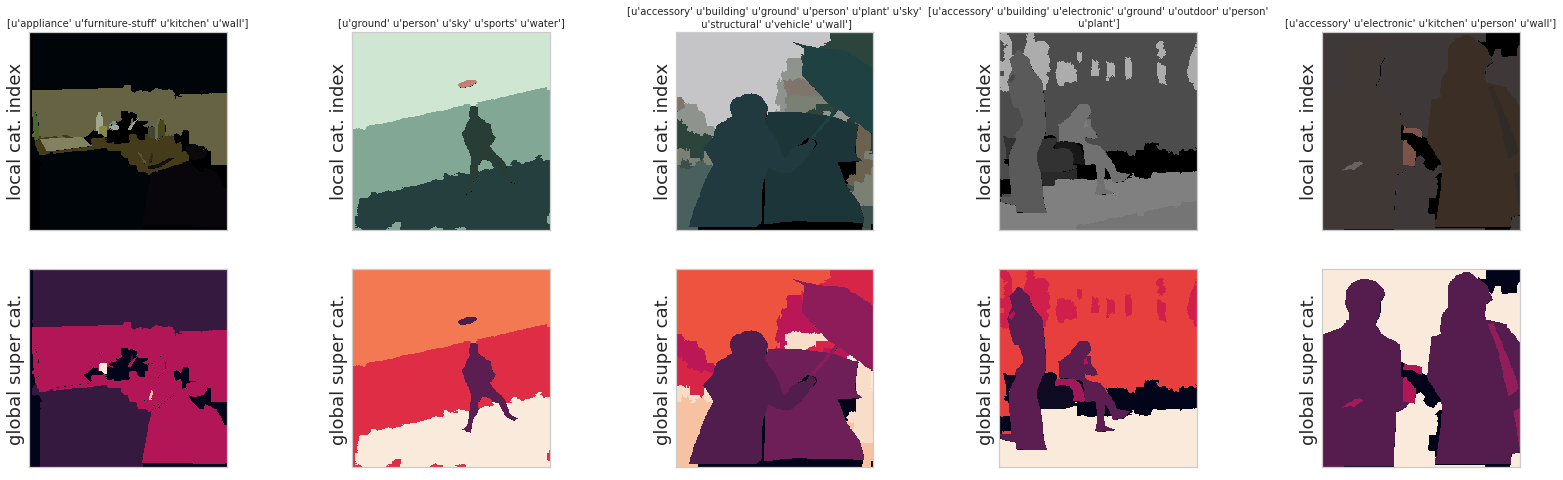

In [160]:
start_idx = 3940
n_idx = 5

plt.figure(figsize=(28,8))
for i,cId in enumerate(cocoMap[start_idx:start_idx+n_idx]):
   
    nId = start_idx + i
    png_name = imgDir + '%012d.png' % cId
    crop = stiminfo['cropBox'][nId]

    img = skimage.io.imread(png_name)
    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')
    catIds = getCategoryIDs(imgIdToAnns[cId], maskToUniqueIndices(croppedImg))
    ###
    plt.subplot(2,n_idx,i+1)
    plt.title(getSupercategoryNames(catIdToCat, catIds), fontsize=10)  
    plt.imshow(croppedImg)
    plt.ylabel('local cat. index')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(2,n_idx,n_idx+i+1)
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    plt.ylabel('global super cat.')
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])

In [162]:
import skimage.io
from skimage.transform import resize
minSize = 227

annDir = '/home/styvesg/repo.data/datasets/coco/'
imgDir = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic/' # combined folder with train2017 and val2017 png masks

cocoCat = {}
for nId,cId in tqdm(enumerate(cocoMap)):
    png_name = imgDir + '%012d.png' % cId
    crop = stiminfo['cropBox'][nId]
    ##
    img = skimage.io.imread(png_name)
    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')    
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    ##
    cocoCat[nId] = {}
    cocoCat[nId]['catId'] = catIds
    cocoCat[nId]['catName'] = getCategoryNames(catIdToCat, catIds)
    cocoCat[nId]['supName'] = getSupercategoryNames(catIdToCat, catIds) 


0it [00:00, ?it/s]
7it [00:00, 69.25it/s]
12it [00:00, 60.69it/s]
18it [00:00, 59.63it/s]
24it [00:00, 56.31it/s]
32it [00:00, 60.62it/s]
41it [00:00, 66.96it/s]
53it [00:00, 76.50it/s]
64it [00:00, 82.59it/s]
75it [00:00, 87.46it/s]
86it [00:01, 92.68it/s]
96it [00:01, 89.96it/s]
106it [00:01, 92.48it/s]
116it [00:01, 93.85it/s]
126it [00:01, 92.10it/s]
136it [00:01, 91.25it/s]
147it [00:01, 94.88it/s]
159it [00:01, 99.75it/s]
170it [00:01, 93.64it/s]
180it [00:02, 80.06it/s]
189it [00:02, 77.31it/s]
200it [00:02, 84.48it/s]
212it [00:02, 91.46it/s]
223it [00:02, 94.57it/s]
234it [00:02, 97.73it/s]
245it [00:02, 101.11it/s]
257it [00:02, 103.51it/s]
269it [00:02, 106.44it/s]
280it [00:03, 97.32it/s] 
290it [00:03, 97.01it/s]
301it [00:03, 98.75it/s]
312it [00:03, 99.15it/s]
323it [00:03, 98.01it/s]
333it [00:03, 97.54it/s]
344it [00:03, 99.89it/s]
355it [00:03, 99.42it/s]
366it [00:03, 101.78it/s]
377it [00:04, 100.80it/s]
389it [00:04, 104.56it/s]
400it [00:04, 105.82it/s]
411it [00

In [163]:
print class_embbeding.keys()

[u'outdoor', u'wall', u'indoor', u'ceiling', u'food-stuff', u'electronic', u'ground', u'floor', u'raw-material', u'sky', u'sports', u'textile', u'window', u'other', u'animal', u'vehicle', u'structural', u'furniture', u'plant', u'food', u'accessory', u'water', u'furniture-stuff', u'kitchen', u'building', u'solid', u'appliance', u'person']


In [164]:
print cocoCat[0]

{'catName': array([u'car', u'house', u'kite', u'person', u'sand', u'sea',
       u'sky-other-merged', u'surfboard', u'tree-merged'], dtype='<U16'), 'supName': array([u'building', u'ground', u'person', u'plant', u'sky', u'sports',
       u'vehicle', u'water'], dtype='<U8'), 'catId': [1, 42, 184, 1, 154, 3, 128, 3, 3, 3, 38, 3, 187, 155]}


In [165]:
emb_dims = np.max(label_map.keys())+1
supEmb = np.zeros(shape=(len(cocoMap), emb_dims), dtype=int)
for k,vv in cocoCat.items():
    for v in vv['supName']:
        i = class_embbeding[v]
        supEmb[k][i] = 1

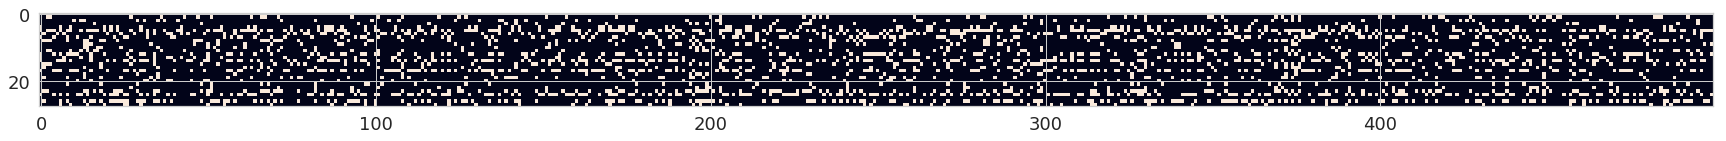

In [166]:
plt.figure(figsize=(30,4))
plt.imshow(supEmb[:500].T)

In [172]:
from src.file_utility import save_stuff, flatten_dict, embed_dict

label_dict = {
    'embedding': supEmb, 
    'label_map': label_map,
    'cocoId': cocoId_arr, 
    'crop': crop_arr, 
    'cocoMap': cocoMap
    }

save_stuff(stim_root + "embedding_73K", flatten_dict(label_dict))

saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved crop in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved embedding in h5py file
saved cocoMap in h5py file
saved cocoId in h5py file


# Label maps for all subjects
This takes a long time since we need to load the image and annotations one-by-one and reinterpret them. 

In [174]:
nx = 227
nc = len(super_nms)

for k in range(len(cocoId_arr)): # for all subjects
    l_image_data = np.zeros(shape=(len(cocoId_arr[k]), nx, nx), dtype=np.uint8)

    for i, (cId, crop) in tqdm(enumerate(zip(cocoId_arr[k], nsdcrop_arr[k]))):
        png_name = imgDir + '%012d.png' % cId
        img = skimage.io.imread(png_name)

        croppedImg = applyCropToImg(img, crop)
        croppedImg = (resize(croppedImg, (nx, nx), order=0) * 255.).astype('uint8')
        l_image_data[i,...] = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
        
    print l_image_data.shape
    save_stuff("%sS%d_supercategory_%d"%(stim_root, k+1, nx), flatten_dict({'labels': l_image_data, 'label_map': label_map, 'label_count': nc}))


0it [00:00, ?it/s]
11it [00:00, 103.60it/s]
22it [00:00, 103.48it/s]
33it [00:00, 104.90it/s]
44it [00:00, 105.48it/s]
56it [00:00, 109.04it/s]
68it [00:00, 111.73it/s]
79it [00:00, 111.09it/s]
91it [00:00, 112.49it/s]
102it [00:00, 105.80it/s]
113it [00:01, 103.80it/s]
124it [00:01, 103.72it/s]
135it [00:01, 101.87it/s]
148it [00:01, 107.54it/s]
159it [00:01, 104.98it/s]
171it [00:01, 106.86it/s]
183it [00:01, 108.16it/s]
195it [00:01, 111.23it/s]
207it [00:01, 113.20it/s]
219it [00:02, 111.39it/s]
231it [00:02, 113.83it/s]
243it [00:02, 111.94it/s]
255it [00:02, 103.34it/s]
266it [00:02, 98.80it/s] 
277it [00:02, 100.37it/s]
289it [00:02, 103.94it/s]
302it [00:02, 107.99it/s]
313it [00:02, 107.63it/s]
324it [00:03, 99.88it/s] 
335it [00:03, 98.72it/s]
346it [00:03, 100.39it/s]
357it [00:03, 100.52it/s]
369it [00:03, 104.96it/s]
380it [00:03, 103.20it/s]
391it [00:03, 100.97it/s]
402it [00:03, 98.35it/s] 
413it [00:03, 101.02it/s]
424it [00:04, 101.71it/s]
435it [00:04, 103.02it/s]
4

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file


0it [00:00, ?it/s]
12it [00:00, 119.79it/s]


saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



26it [00:00, 122.63it/s]
36it [00:00, 112.83it/s]
49it [00:00, 116.78it/s]
61it [00:00, 114.70it/s]
73it [00:00, 114.18it/s]
85it [00:00, 114.91it/s]
97it [00:00, 114.54it/s]
108it [00:00, 113.05it/s]
121it [00:01, 115.77it/s]
134it [00:01, 117.79it/s]
147it [00:01, 120.42it/s]
160it [00:01, 121.02it/s]
173it [00:01, 117.92it/s]
185it [00:01, 115.63it/s]
197it [00:01, 116.77it/s]
209it [00:01, 113.13it/s]
221it [00:01, 114.84it/s]
233it [00:02, 113.72it/s]
245it [00:02, 115.52it/s]
257it [00:02, 111.92it/s]
269it [00:02, 112.30it/s]
281it [00:02, 114.37it/s]
293it [00:02, 111.36it/s]
305it [00:02, 109.37it/s]
316it [00:02, 106.22it/s]
328it [00:02, 109.54it/s]
340it [00:02, 111.02it/s]
353it [00:03, 114.27it/s]
366it [00:03, 118.09it/s]
379it [00:03, 119.89it/s]
392it [00:03, 119.85it/s]
405it [00:03, 117.12it/s]
417it [00:03, 116.27it/s]
429it [00:03, 112.63it/s]
441it [00:03, 108.36it/s]
453it [00:03, 110.05it/s]
465it [00:04, 108.09it/s]
478it [00:04, 112.32it/s]
490it [00:04, 110.

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file



0it [00:00, ?it/s]
12it [00:00, 117.88it/s]

saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



23it [00:00, 112.83it/s]
35it [00:00, 113.89it/s]
46it [00:00, 111.19it/s]
58it [00:00, 108.79it/s]
67it [00:00, 89.95it/s] 
78it [00:00, 94.40it/s]
90it [00:00, 99.10it/s]
101it [00:00, 99.81it/s]
113it [00:01, 105.09it/s]
126it [00:01, 110.01it/s]
138it [00:01, 107.67it/s]
149it [00:01, 106.14it/s]
160it [00:01, 106.96it/s]
171it [00:01, 103.87it/s]
182it [00:01, 101.95it/s]
193it [00:01, 102.65it/s]
205it [00:01, 107.10it/s]
216it [00:02, 103.39it/s]
228it [00:02, 106.72it/s]
240it [00:02, 107.99it/s]
251it [00:02, 107.20it/s]
263it [00:02, 109.59it/s]
275it [00:02, 109.37it/s]
287it [00:02, 110.34it/s]
299it [00:02, 111.28it/s]
311it [00:02, 96.43it/s] 
323it [00:03, 101.64it/s]
334it [00:03, 102.98it/s]
345it [00:03, 104.87it/s]
357it [00:03, 107.65it/s]
368it [00:03, 104.95it/s]
379it [00:03, 101.56it/s]
390it [00:03, 84.23it/s] 
399it [00:03, 80.77it/s]
409it [00:04, 84.11it/s]
419it [00:04, 87.57it/s]
429it [00:04, 80.67it/s]
439it [00:04, 85.29it/s]
451it [00:04, 92.03it/s]
4

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



24it [00:00, 119.18it/s]
33it [00:00, 106.79it/s]
43it [00:00, 104.65it/s]
56it [00:00, 109.73it/s]
68it [00:00, 112.54it/s]
79it [00:00, 111.76it/s]
92it [00:00, 115.24it/s]
103it [00:00, 109.34it/s]
115it [00:01, 109.78it/s]
127it [00:01, 108.79it/s]
138it [00:01, 108.26it/s]
150it [00:01, 109.92it/s]
162it [00:01, 110.78it/s]
174it [00:01, 112.94it/s]
186it [00:01, 111.83it/s]
199it [00:01, 115.69it/s]
211it [00:01, 113.66it/s]
224it [00:02, 116.22it/s]
236it [00:02, 110.84it/s]
248it [00:02, 111.36it/s]
260it [00:02, 109.61it/s]
272it [00:02, 110.22it/s]
284it [00:02, 111.95it/s]
296it [00:02, 111.34it/s]
308it [00:02, 105.97it/s]
319it [00:02, 102.29it/s]
330it [00:03, 98.64it/s] 
342it [00:03, 103.09it/s]
353it [00:03, 105.03it/s]
365it [00:03, 107.97it/s]
377it [00:03, 109.96it/s]
389it [00:03, 109.54it/s]
401it [00:03, 108.86it/s]
412it [00:03, 105.09it/s]
424it [00:03, 108.54it/s]
435it [00:03, 106.02it/s]
446it [00:04, 105.43it/s]
457it [00:04, 102.28it/s]
468it [00:04, 102.

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



26it [00:00, 127.32it/s]
38it [00:00, 124.24it/s]
51it [00:00, 124.79it/s]
64it [00:00, 124.21it/s]
78it [00:00, 126.92it/s]
92it [00:00, 128.37it/s]
104it [00:00, 125.55it/s]
118it [00:00, 127.00it/s]
131it [00:01, 123.21it/s]
144it [00:01, 123.50it/s]
157it [00:01, 121.01it/s]
169it [00:01, 118.02it/s]
182it [00:01, 119.18it/s]
194it [00:01, 114.07it/s]
206it [00:01, 114.34it/s]
218it [00:01, 108.82it/s]
231it [00:01, 112.74it/s]
243it [00:02, 112.55it/s]
255it [00:02, 114.60it/s]
267it [00:02, 114.07it/s]
279it [00:02, 114.62it/s]
292it [00:02, 117.52it/s]
304it [00:02, 117.31it/s]
316it [00:02, 115.62it/s]
328it [00:02, 115.65it/s]
340it [00:02, 115.89it/s]
352it [00:02, 117.06it/s]
364it [00:03, 114.01it/s]
376it [00:03, 115.31it/s]
388it [00:03, 110.29it/s]
400it [00:03, 110.15it/s]
412it [00:03, 109.96it/s]
424it [00:03, 109.90it/s]
436it [00:03, 106.88it/s]
448it [00:03, 109.23it/s]
461it [00:03, 112.96it/s]
473it [00:04, 113.19it/s]
486it [00:04, 116.72it/s]
498it [00:04, 105

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



25it [00:00, 115.96it/s]
37it [00:00, 115.54it/s]
51it [00:00, 120.02it/s]
64it [00:00, 122.41it/s]
78it [00:00, 125.47it/s]
90it [00:00, 122.04it/s]
102it [00:00, 116.73it/s]
114it [00:00, 112.15it/s]
126it [00:01, 113.87it/s]
138it [00:01, 110.35it/s]
149it [00:01, 100.25it/s]
160it [00:01, 98.67it/s] 
171it [00:01, 101.72it/s]
182it [00:01, 100.10it/s]
194it [00:01, 103.87it/s]
206it [00:01, 105.89it/s]
217it [00:01, 105.27it/s]
229it [00:02, 108.96it/s]
240it [00:02, 104.99it/s]
252it [00:02, 107.46it/s]
264it [00:02, 109.98it/s]
276it [00:02, 110.74it/s]
289it [00:02, 113.97it/s]
302it [00:02, 115.58it/s]
314it [00:02, 116.06it/s]
326it [00:02, 116.02it/s]
338it [00:03, 110.55it/s]
351it [00:03, 113.83it/s]
363it [00:03, 112.15it/s]
375it [00:03, 113.45it/s]
387it [00:03, 113.28it/s]
399it [00:03, 110.49it/s]
411it [00:03, 112.73it/s]
423it [00:03, 109.38it/s]
435it [00:03, 109.71it/s]
447it [00:04, 106.99it/s]
459it [00:04, 109.18it/s]
470it [00:04, 108.07it/s]
481it [00:04, 106

(10000, 227, 227)
saved labels in h5py file


0it [00:00, ?it/s]
13it [00:00, 129.84it/s]


saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



24it [00:00, 123.00it/s]
37it [00:00, 121.91it/s]
45it [00:00, 104.48it/s]
58it [00:00, 109.00it/s]
71it [00:00, 112.99it/s]
84it [00:00, 116.31it/s]
97it [00:00, 119.75it/s]
109it [00:00, 119.39it/s]
121it [00:01, 119.38it/s]
133it [00:01, 115.87it/s]
145it [00:01, 116.99it/s]
157it [00:01, 112.74it/s]
169it [00:01, 109.35it/s]
181it [00:01, 110.12it/s]
193it [00:01, 112.28it/s]
205it [00:01, 110.99it/s]
217it [00:01, 110.18it/s]
229it [00:02, 112.22it/s]
241it [00:02, 111.31it/s]
253it [00:02, 112.69it/s]
265it [00:02, 110.09it/s]
278it [00:02, 113.75it/s]
291it [00:02, 115.94it/s]
303it [00:02, 116.21it/s]
316it [00:02, 118.62it/s]
329it [00:02, 120.37it/s]
342it [00:02, 115.44it/s]
355it [00:03, 118.86it/s]
367it [00:03, 118.80it/s]
380it [00:03, 120.03it/s]
393it [00:03, 117.90it/s]
405it [00:03, 116.69it/s]
417it [00:03, 107.54it/s]
428it [00:03, 107.61it/s]
440it [00:03, 108.04it/s]
451it [00:03, 106.48it/s]
463it [00:04, 108.37it/s]
474it [00:04, 107.89it/s]
486it [00:04, 111.

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file



26it [00:00, 126.83it/s]
37it [00:00, 120.90it/s]
50it [00:00, 123.36it/s]
61it [00:00, 118.59it/s]
75it [00:00, 121.68it/s]
86it [00:00, 115.31it/s]
99it [00:00, 117.74it/s]
111it [00:00, 114.65it/s]
123it [00:01, 114.73it/s]
135it [00:01, 115.82it/s]
147it [00:01, 113.64it/s]
159it [00:01, 114.40it/s]
171it [00:01, 109.52it/s]
184it [00:01, 113.40it/s]
196it [00:01, 114.97it/s]
209it [00:01, 117.26it/s]
221it [00:01, 117.76it/s]
234it [00:02, 119.94it/s]
247it [00:02, 121.13it/s]
260it [00:02, 118.80it/s]
272it [00:02, 115.33it/s]
285it [00:02, 118.08it/s]
297it [00:02, 115.47it/s]
310it [00:02, 117.35it/s]
322it [00:02, 117.22it/s]
334it [00:02, 116.21it/s]
346it [00:02, 114.35it/s]
358it [00:03, 115.50it/s]
372it [00:03, 119.42it/s]
384it [00:03, 113.42it/s]
396it [00:03, 114.12it/s]
408it [00:03, 112.43it/s]
421it [00:03, 116.29it/s]
434it [00:03, 118.55it/s]
446it [00:03, 116.42it/s]
458it [00:03, 115.99it/s]
471it [00:04, 118.64it/s]
484it [00:04, 120.74it/s]
497it [00:04, 118.

(10000, 227, 227)
saved labels in h5py file
saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved label_count in h5py file
